# Titanic Dataset - Classification
### Genesis Adam D. Mendoza

Initialize the required packages

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [9]:
file_path = '..\\datasets\\Titanic Dataset\\'
titanic = pd.read_csv(file_path + 'train.csv', index_col = 'PassengerId')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


array([[<Axes: title={'center': 'Pclass'}>,
        <Axes: title={'center': 'Age'}>],
       [<Axes: title={'center': 'SibSp'}>,
        <Axes: title={'center': 'Parch'}>],
       [<Axes: title={'center': 'Fare'}>, <Axes: >]], dtype=object)

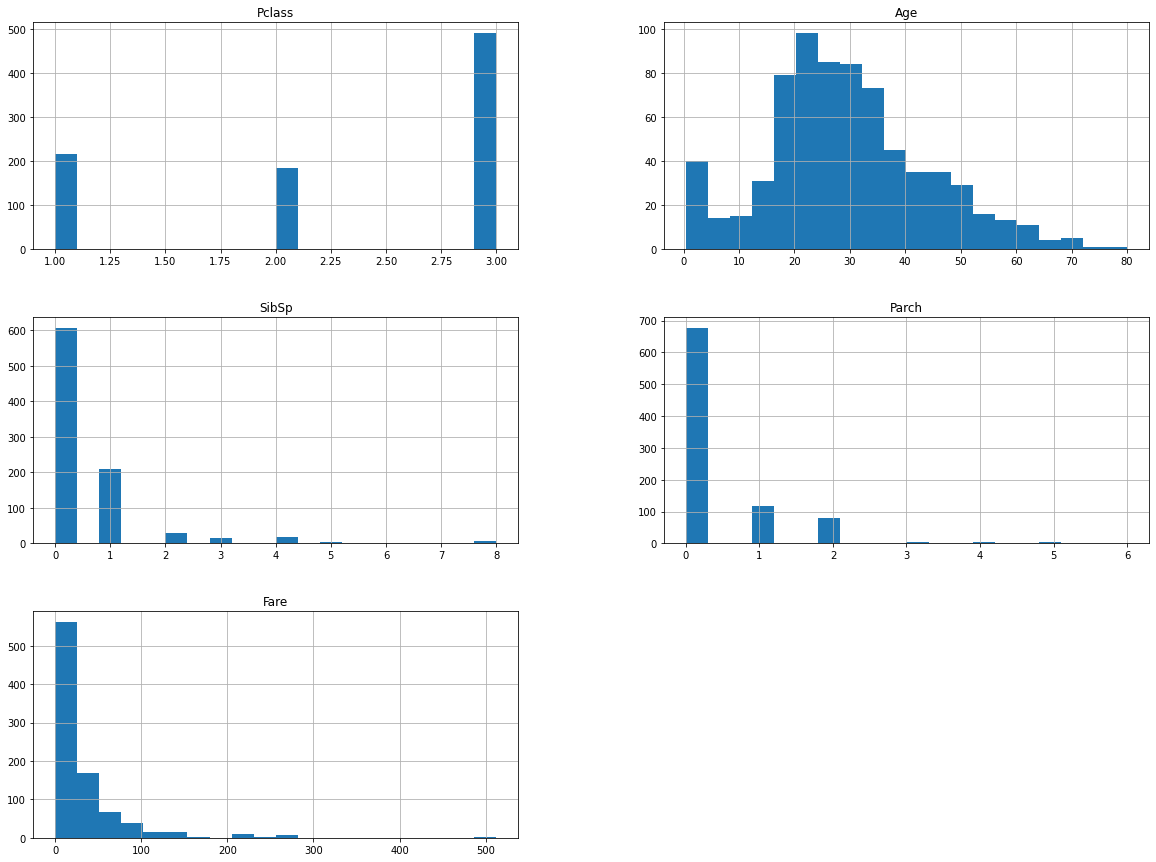

In [10]:
titanic.drop('Survived', axis = 1).hist(bins=20,figsize=(20,15))

From Kaggle:

## Data Dictionary

| Variable | Definition | Key |
|----------|------------|-----|
| survival | Survival   | 0 = No, 1 = Yes |
| pclass   | Ticket class| 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex      | Sex        |     |
| Age      | Age in years|     |
| sibsp    | # of siblings / spouses aboard the Titanic |     |
| parch    | # of parents / children aboard the Titanic |     |
| ticket   | Ticket number|     |
| fare     | Passenger fare|     |
| cabin    | Cabin number |     |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

### Variable Notes

- **pclass**: A proxy for socio-economic status (SES)
  - 1st = Upper
  - 2nd = Middle
  - 3rd = Lower

- **age**: Age is fractional if less than 1. If the age is estimated, it is in the form of xx.5.

- **sibsp**: The dataset defines family relations in this way...
  - Sibling = brother, sister, stepbrother, stepsister
  - Spouse = husband, wife (mistresses and fiancés were ignored)

- **parch**: The dataset defines family relations in this way...
  - Parent = mother, father
  - Child = daughter, son, stepdaughter, stepson
  - Some children travelled only with a nanny, therefore parch=0 for them.


Check if there are any columns that have null values.

In [11]:
null_cols = [col for col in titanic.columns if titanic[col].isnull().any()]
null_cols

['Age', 'Cabin', 'Embarked']

What percentage of the entries in this columns are empty?

In [12]:
100*titanic[null_cols].isnull().sum()/titanic[null_cols].shape[0]

Age         19.865320
Cabin       77.104377
Embarked     0.224467
dtype: float64

We will fill the null age columns with the mean value.

In [13]:
titanic['Age'] = titanic['Age'].fillna(value = titanic.Age.median()).astype('float64')

Suppose we don't want to remove the Cabin feature even though 77% of it is missing. We can extract useful information from these strings.

In [14]:
titanic['Honorific'] = titanic['Name'].str.extract('([A-Za-z]+)\.') #separate the honorific from the name. It may indicate social status.
titanic['Surname'] = titanic['Name'].str.extract('([A-Za-z]+)\,') #separate the surname from the name. It may indicate social status and lineage.
titanic['CabinName'] = titanic.Cabin.str.extract(r'([A-Z])') #cabin name may also indicate social status. 
titanic['CabinNumber'] = titanic.Cabin.str.extract(r'(\d+)', expand=False).fillna(value = 0).astype('int64') #cabin number may also indicate social status. 
titanic['TicketPrefix'] = titanic['Ticket'].str.extract(r'([a-zA-Z0-9/.]+)\s') #the prefix of the ticket may indicate the location where they have embarked
titanic['TicketNumeric'] = titanic['Ticket'].str.extract(r'(\d+)$').fillna(value = 0).astype('int64') #the numerical value of the ticket may indicate who's with who
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorific,Surname,CabinName,CabinNumber,TicketPrefix,TicketNumeric
PassengerId,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,NaN,0,A/5,21171
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,C,85,PC,17599
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,NaN,0,STON/O2.,3101282
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,C,123,NaN,113803
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,NaN,0,NaN,373450


Can the ticket say something more about the passengers? Well, I think it can give an accurate number of companions in the trip.

In [15]:
titanic['SimilarTicket'] = titanic.groupby('TicketNumeric')['TicketNumeric'].transform('count') - 1
titanic['SimilarTicket'] = titanic['SimilarTicket'].fillna(value = 0).astype('int64')
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorific,Surname,CabinName,CabinNumber,TicketPrefix,TicketNumeric,SimilarTicket
PassengerId,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,NaN,0,A/5,21171,0
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,C,85,PC,17599,0
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,NaN,0,STON/O2.,3101282,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,C,123,NaN,113803,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,NaN,0,NaN,373450,0


Take `TicketNumeric == 110152` for example. 

In [16]:
titanic[titanic.TicketNumeric == 110152]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorific,Surname,CabinName,CabinNumber,TicketPrefix,TicketNumeric,SimilarTicket
PassengerId,,,,,,,,,,,,,,,,,,
258,1,1,"Cherry, Miss. Gladys",female,30.0,0,0,110152,86.5,B77,S,Miss,Cherry,B,77,NaN,110152,2
505,1,1,"Maioni, Miss. Roberta",female,16.0,0,0,110152,86.5,B79,S,Miss,Maioni,B,79,NaN,110152,2
760,1,1,"Rothes, the Countess. of (Lucy Noel Martha Dye...",female,33.0,0,0,110152,86.5,B77,S,Countess,Rothes,B,77,NaN,110152,2


They have no siblings, spouses, parents, or children on board. Also, take `TicketNumeric == 9549`.

In [17]:
titanic[titanic.TicketNumeric == 9549]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorific,Surname,CabinName,CabinNumber,TicketPrefix,TicketNumeric,SimilarTicket
PassengerId,,,,,,,,,,,,,,,,,,
11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.0,1,1,PP 9549,16.7,G6,S,Miss,Sandstrom,G,6,PP,9549,1
395,1,3,"Sandstrom, Mrs. Hjalmar (Agnes Charlotta Bengt...",female,24.0,0,2,PP 9549,16.7,G6,S,Mrs,Sandstrom,G,6,PP,9549,1


We're supposed to have three people on board. Our strategy will be: the amount of companion is determined by the largest number between `SibSp + Parch` or `Ticket Numeric` counts.

In [18]:
Rel = titanic.SibSp + titanic.Parch
n_Companion = []

for i in range(len(titanic.index)):
    if Rel.iloc[i] >= titanic.SimilarTicket.iloc[i]:
        n_Companion.append(Rel.iloc[i])
    else:
        n_Companion.append(titanic.SimilarTicket.iloc[i])

n_Companion = pd.DataFrame(n_Companion, index = titanic.index, columns = ['n_Companion'])
titanic['Companion'] = n_Companion
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Honorific,Surname,CabinName,CabinNumber,TicketPrefix,TicketNumeric,SimilarTicket,Companion
PassengerId,,,,,,,,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr,Braund,NaN,0,A/5,21171,0,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs,Cumings,C,85,PC,17599,0,1
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss,Heikkinen,NaN,0,STON/O2.,3101282,0,0
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs,Futrelle,C,123,NaN,113803,1,1
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr,Allen,NaN,0,NaN,373450,0,0


Drop the unnecessary columns

In [19]:
titanic_dropped = titanic.drop(['Name', 'Cabin', 'Ticket', 'TicketPrefix', 'SimilarTicket'], axis = 1) #drop the original columns.
titanic_dropped.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Honorific,Surname,CabinName,CabinNumber,TicketNumeric,Companion
PassengerId,,,,,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Mr,Braund,NaN,0,21171,1
2,1,1,female,38.0,1,0,71.2833,C,Mrs,Cumings,C,85,17599,1
3,1,3,female,26.0,0,0,7.9250,S,Miss,Heikkinen,NaN,0,3101282,0
4,1,1,female,35.0,1,0,53.1000,S,Mrs,Futrelle,C,123,113803,1
5,0,3,male,35.0,0,0,8.0500,S,Mr,Allen,NaN,0,373450,0


Next, we separate the target columns from the feature columns. Then, we'll separate the training set and the validation set.

In [20]:
target_cols = ['Survived']
feature_cols = [col for col in titanic_dropped.columns if col not in target_cols]

x_feats = titanic_dropped[feature_cols]
y_targ = titanic_dropped[target_cols]
x_train, x_val, y_train, y_val = train_test_split(x_feats, y_targ, train_size=0.5, random_state=0)

We categorize the feature columns into numerical or categorical so that we'll know how to process it.

In [21]:
num_cols = [col for col in feature_cols if titanic_dropped[col].dtype in ['int64', 'float64']]
cat_cols = [col for col in feature_cols if titanic_dropped[col].dtype in ['object']]                                                                                   

In [22]:
categorical_transformer = Pipeline(steps = [('imputer', SimpleImputer(strategy = 'most_frequent')),('onehot', OneHotEncoder(handle_unknown = 'ignore'))])
preprocessor = ColumnTransformer(transformers=[('cat', categorical_transformer, cat_cols)])

Let's check the correlation between numerical columns

In [23]:
titanic_dropped[num_cols + ['Survived']].corr()*100

,Pclass,Age,SibSp,Parch,Fare,CabinNumber,TicketNumeric,Companion,Survived
Pclass,100.000000,-33.989833,8.308136,1.844267,-54.949962,-57.330241,28.401605,1.492641,-33.848104
Age,-33.989833,100.000000,-23.329633,-17.248195,9.668842,19.760718,-10.026498,-22.922642,-6.491042
SibSp,8.308136,-23.329633,100.000000,41.483770,15.965104,-3.874046,4.694203,80.909147,-3.532250
Parch,1.844267,-17.248195,41.483770,100.000000,21.622494,0.164006,-3.252979,69.976605,8.162941
Fare,-54.949962,9.668842,15.965104,21.622494,100.000000,40.561858,-15.537106,33.424997,25.730652
CabinNumber,-57.330241,19.760718,-3.874046,0.164006,40.561858,100.000000,-14.586374,0.010714,22.975624
TicketNumeric,28.401605,-10.026498,4.694203,-3.252979,-15.537106,-14.586374,100.000000,-2.967405,-9.560544
Companion,1.492641,-22.922642,80.909147,69.976605,33.424997,0.010714,-2.967405,100.000000,6.480234
Survived,-33.848104,-6.491042,-3.532250,8.162941,25.730652,22.975624,-9.560544,6.480234,100.000000


We will now tweak the test data accordingly.

In [24]:
titanic_test = pd.read_csv(file_path + 'test.csv', index_col = 'PassengerId')
titanic_test['Age'] = titanic['Age'].fillna(value = titanic.Age.mean()).astype('float64')
titanic_test['Honorific'] = titanic_test['Name'].str.extract('([A-Za-z]+)\.')
titanic_test['Surname'] = titanic_test['Name'].str.extract('([A-Za-z]+)\,')
titanic_test['CabinName'] = titanic_test.Cabin.str.extract(r'([A-Z])')
titanic_test['CabinNumber'] = titanic_test.Cabin.str.extract(r'(\d+)', expand=False).fillna(value = 0).astype('int64') 
titanic_test['TicketPrefix'] = titanic_test['Ticket'].str.extract(r'([a-zA-Z0-9/.]+)\s')
titanic_test['TicketNumeric'] = titanic_test['Ticket'].str.extract(r'(\d+)$').fillna(value = 0).astype('int64')
titanic_test['SimilarTicket'] = titanic_test.groupby('TicketNumeric')['TicketNumeric'].transform('count') - 1
titanic_test['SimilarTicket'] = titanic_test['SimilarTicket'].fillna(value = 0).astype('int64')

Rel = titanic_test.SibSp + titanic_test.Parch
n_Companion = []

for i in range(len(titanic_test.index)):
    if Rel.iloc[i] >= titanic_test.SimilarTicket.iloc[i]:
        n_Companion.append(Rel.iloc[i])
    else:
        n_Companion.append(titanic_test.SimilarTicket.iloc[i])

n_Companion = pd.DataFrame(n_Companion, index = titanic_test.index, columns = ['n_Companion'])
titanic_test['Companion'] = n_Companion

titanic_test_dropped = titanic_test.drop(['Name', 'Cabin', 'Ticket', 'TicketPrefix', 'SimilarTicket'], axis = 1)

good_cols = [col for col in feature_cols if col in titanic_test_dropped.columns]
x_deploy = titanic_test[good_cols]
titanic_test_dropped.head()

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Honorific,Surname,CabinName,CabinNumber,TicketNumeric,Companion
PassengerId,,,,,,,,,,,,,
892,3,male,NaN,0,0,7.8292,Q,Mr,Kelly,NaN,0,330911,0
893,3,female,NaN,1,0,7.0000,S,Mrs,Wilkes,NaN,0,363272,1
894,2,male,NaN,0,0,9.6875,Q,Mr,Myles,NaN,0,240276,0
895,3,male,NaN,0,0,8.6625,S,Mr,Wirz,NaN,0,315154,0
896,3,female,NaN,1,1,12.2875,S,Mrs,Hirvonen,NaN,0,3101298,2


Originally, I've used the following code to search for the optimal parameters and to deploy the model. It is computationally expensive (it took me 38 minutes to run this code) so we'll use a different approach.

In [25]:
"""
params = {}
for node_val in range(10,500,50):
    for estim in range(1, 200, 20):
        for depth in range(1, 100, 1):
            model = RandomForestClassifier(n_estimators = estim, max_leaf_nodes = node_val, max_depth = depth, random_state = 0)
            pipeline = Pipeline(steps = [('preprocess', preprocessor),('model', model)])
            pipeline.fit(x_train, y_train.values.ravel())
            predicted_vals = pipeline.predict(x_val)
            y_pred = pd.DataFrame(predicted_vals, index = y_val.index, columns = ['SurvivedPred'])
            correct = y_pred.SurvivedPred[y_pred.SurvivedPred == y_val.Survived].count()
            total = y_val.Survived.count()
            params[(node_val, estim, depth)] = 100*correct/total
optimal_params = max(params, key = params.get)
opt_nodes, opt_estim, opt_depth = optimal_params
print('The optimal parameters are (max_leaf_nodes, n_estimators, max_depth) = {} with an accuracy of {:.2f}%'.format(optimal_params, params[optimal_params]))

model = RandomForestClassifier(n_estimators = opt_estim, max_leaf_nodes = opt_nodes, max_depth = opt_depth, random_state = 0)
pipeline = Pipeline(steps = [('preprocess', preprocessor),('model', model)])
pipeline.fit(x_feats, y_targ.values.ravel())
final_pred = pipeline.predict(x_deploy)

output = pd.DataFrame({'PassengerId': titanic_test.index, 'Survived': final_pred})
output.to_csv('titanic_predict.csv', index=False)
"""

"\nparams = {}\nfor node_val in range(10,500,50):\n    for estim in range(1, 200, 20):\n        for depth in range(1, 100, 1):\n            model = RandomForestClassifier(n_estimators = estim, max_leaf_nodes = node_val, max_depth = depth, random_state = 0)\n            pipeline = Pipeline(steps = [('preprocess', preprocessor),('model', model)])\n            pipeline.fit(x_train, y_train.values.ravel())\n            predicted_vals = pipeline.predict(x_val)\n            y_pred = pd.DataFrame(predicted_vals, index = y_val.index, columns = ['SurvivedPred'])\n            correct = y_pred.SurvivedPred[y_pred.SurvivedPred == y_val.Survived].count()\n            total = y_val.Survived.count()\n            params[(node_val, estim, depth)] = 100*correct/total\noptimal_params = max(params, key = params.get)\nopt_nodes, opt_estim, opt_depth = optimal_params\nprint('The optimal parameters are (max_leaf_nodes, n_estimators, max_depth) = {} with an accuracy of {:.2f}%'.format(optimal_params, params[o

Now, I'll use RandomizedSearchCV. Here, we won't use the validation set since it uses cross-validation.

In [26]:
model = RandomForestClassifier(random_state=0)
pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])

max_leaf_nodes = [node_val for node_val in range(1, 500, 1)]
max_depth = [depth for depth in range(1, 100, 1)]
min_samples_split = [*range(2, 20, 1)]
min_samples_leaf = [*range(1, 10, 1)]

random_grid = {'model__max_leaf_nodes': max_leaf_nodes, 
               'model__max_depth': max_depth, 
               'model__min_samples_split': min_samples_split, 
               'model__min_samples_leaf': min_samples_leaf}
n_estimators = [estim for estim in range(1, 200, 1)]

model_random = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions={**random_grid, 'model__n_estimators': n_estimators},
    n_iter=200, cv=3, verbose=3, random_state=0, n_jobs=-1
)

model_random.fit(x_feats, y_targ.values.ravel())

opt_estim = model_random.best_params_['model__n_estimators']
opt_nodes = model_random.best_params_['model__max_leaf_nodes']
opt_depth = model_random.best_params_['model__max_depth']
opt_minsplit = model_random.best_params_['model__min_samples_split']
opt_minleaf = model_random.best_params_['model__min_samples_leaf']

print('Optimal estimators: {}'.format(opt_estim))
print('Optimal maximum leaf nodes: {}'.format(opt_nodes))
print('Optimal depth: {}'.format(opt_depth))
print('Optimal minimum number of samples to split: {}'.format(opt_minsplit))
print('Optimal minimum leaves per node: {}'.format(opt_minleaf))
print('The best score given the optimum parameters is {:.2f}%'.format(100*model_random.best_score_))

Fitting 3 folds for each of 200 candidates, totalling 600 fits


Optimal estimators: 21
Optimal maximum leaf nodes: 428
Optimal depth: 71
Optimal minimum number of samples to split: 3
Optimal minimum leaves per node: 1
The best score given the optimum parameters is 81.59%


In [27]:
model = GradientBoostingClassifier(random_state=0)
pipeline = Pipeline(steps=[('preprocess', preprocessor), ('model', model)])

model_random = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions={**random_grid, 'model__n_estimators': n_estimators},
    n_iter=200, cv=3, verbose=3, random_state=0, n_jobs=-1
)

model_random.fit(x_feats, y_targ.values.ravel())

opt_estim = model_random.best_params_['model__n_estimators']
opt_nodes = model_random.best_params_['model__max_leaf_nodes']
opt_depth = model_random.best_params_['model__max_depth']
opt_minsplit = model_random.best_params_['model__min_samples_split']
opt_minleaf = model_random.best_params_['model__min_samples_leaf']

print('Optimal estimators: {}'.format(opt_estim))
print('Optimal maximum leaf nodes: {}'.format(opt_nodes))
print('Optimal depth: {}'.format(opt_depth))
print('Optimal minimum number of samples to split: {}'.format(opt_minsplit))
print('Optimal minimum leaves per node: {}'.format(opt_minleaf))
print('The best score given the optimum parameters is {:.2f}%'.format(100*model_random.best_score_))

Fitting 3 folds for each of 200 candidates, totalling 600 fits
Optimal estimators: 195
Optimal maximum leaf nodes: 46
Optimal depth: 38
Optimal minimum number of samples to split: 4
Optimal minimum leaves per node: 1
The best score given the optimum parameters is 83.61%


We will now deploy the model.

In [28]:
""""
model = RandomForestClassifier(n_estimators = opt_estim, 
                               max_leaf_nodes = opt_nodes, 
                               max_depth = opt_depth, 
                               min_samples_split = opt_minsplit, 
                               min_samples_leaf = opt_minleaf, 
                               random_state = 0)
pipeline = Pipeline(steps = [('preprocess', preprocessor),('model', model)])
pipeline.fit(x_feats, y_targ.values.ravel())
final_pred = pipeline.predict(x_deploy)

output = pd.DataFrame({'PassengerId': titanic_test.index, 'Survived': final_pred})
output.to_csv('titanic_predict_rscv(dt).csv', index=False)
"""

'"\nmodel = RandomForestClassifier(n_estimators = opt_estim, \n                               max_leaf_nodes = opt_nodes, \n                               max_depth = opt_depth, \n                               min_samples_split = opt_minsplit, \n                               min_samples_leaf = opt_minleaf, \n                               random_state = 0)\npipeline = Pipeline(steps = [(\'preprocess\', preprocessor),(\'model\', model)])\npipeline.fit(x_feats, y_targ.values.ravel())\nfinal_pred = pipeline.predict(x_deploy)\n\noutput = pd.DataFrame({\'PassengerId\': titanic_test.index, \'Survived\': final_pred})\noutput.to_csv(\'titanic_predict_rscv(dt).csv\', index=False)\n'